# Example 3: Normalize data to MNI template

This example covers the normalization of data. Some people prefer to normalize the data during the preprocessing, just before smoothing. I prefer to do the 1st-level analysis completely in subject space and only normalize the contrasts for the 2nd-level analysis. But both approaches are fine.

For the current example, we will take the computed 1st-level contrasts from the previous experiment (again once done with fwhm=4mm and fwhm=8mm) and normalize them into MNI-space. To show two different approaches, we will do the normalization once with ANTs and once with SPM.

## Normalization with ANTs

The normalization with ANTs requires that you first compute the transformation matrix that would bring the anatomical images of each subject into template space. Depending on your system this might take a few hours per subject. To facilitate this step, the transformation matrix is already computed for the T1 images.

The data for it can be found under:

In [1]:
#!ls /data/derivatives/fmriprep/sub-*/anat/*h5

If you want to compute the transformation matrix yourself, either use [fmriprep](http://fmriprep.readthedocs.io), as in our example dataset.

Alternatively, you can also create a ANTS registration pipeline yourself. An example of such a pipeline would look as follows (**note, that you can load the script to see the workflow, but you don't have to run it, we will NOT use the output of the workflow in this nothebook**):

In [2]:
#load scripts/ANTS_registration.py


**Now, let's start with the ANTs normalization workflow!**

## Imports (ANTs)

First, we need to import all modules we later want to use.

In [3]:
from os.path import join as opj
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.fsl import Info

## Experiment parameters (ANTs)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. And remember that we decided to run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left handed (see [this section](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Special-case)).

In [4]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers (remember we use only right handed subjects)
subject_list = ['sub-222', 'sub-256', 'sub-270']

# task name
task_name = "emp"

# Smoothing widths used during preprocessing
fwhm = [4, 8]

# Template to normalize to
template = '/data/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

**Note** that the **``template``** file might not be in your ``data``  directory. To get ``mni_icbm152_nlin_asym_09c``, either download it from this [website](https://files.osf.io/v1/resources/fvuh8/providers/osfstorage/580705089ad5a101f17944a9), unpack it and move it to ``/data/ds000114/derivatives/fmriprep/`` or run the following command in a cell:

```bash
%%bash
curl -L https://files.osf.io/v1/resources/fvuh8/providers/osfstorage/580705089ad5a101f17944a9 \
     -o /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz
     
tar xf /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz \
    -C /data/ds000114/derivatives/fmriprep/.
    
rm /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz
```

## Specify Nodes (ANTs)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [5]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

## Specify input & output stream (ANTs)

Specify where the input data can be found & where and how to save the output data.

In [6]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        '{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'transform': opj('/data/derivatives/fmriprep/', '{subject_id}', 'anat',
                              '{subject_id}_t1w_space-mni152nlin2009casym_warp.h5')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
subjFolders += [('_apply2con%s/' % (i), '') for i in range(9)] # number of contrast used in 1stlevel an.
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (ANTs)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [7]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                            ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'norm_ants.@con')]),
                  ])

## Visualize the workflow (ANTs)

It always helps to visualize your workflow.

170928-23:28:20,983 workflow INFO:
	 Generated workflow graph: /output/workingdir/antsflow/graph.dot.png (graph2use=colored, simple_form=True).


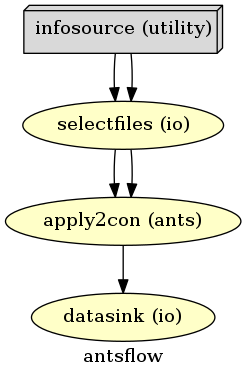

In [8]:
# Create ANTs normalization graph
antsflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(antsflow.base_dir, 'antsflow', 'graph.dot.png'))

##  Run the Workflow (ANTs)

Now that everything is ready, we can run the ANTs normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [9]:
antsflow.run('MultiProc', plugin_args={'n_procs': 4})

170928-23:28:21,61 workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging']
170928-23:28:21,126 workflow INFO:
	 Running in parallel.
170928-23:28:21,131 workflow INFO:
	 Executing: selectfiles.a5 ID: 0
170928-23:28:21,153 workflow INFO:
	 Executing: selectfiles.a4 ID: 3
170928-23:28:21,155 workflow INFO:
	 Executing node selectfiles.a5 in dir: /output/workingdir/antsflow/_fwhm_id_8_subject_id_sub-270/selectfiles
170928-23:28:21,180 workflow INFO:
	 Executing: selectfiles.a3 ID: 6
170928-23:28:21,184 workflow INFO:
	 Executing node selectfiles.a4 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-270/selectfiles
170928-23:28:21,220 workflow INFO:
	 Executing: selectfiles.a2 ID: 9
170928-23:28:21,223 workflow INFO:
	 Executing node selectfiles.a3 in dir: /output/workingdir/antsflow/_fwhm_id_8_subject_id_sub-256/selectfiles
170928-23:28:21,247 workflow INFO:
	 Executing node selectfiles.a2 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-256/

	 Running: antsApplyTransforms --float --default-value 0 --input /output/datasink/1stLevel/sub-270/fwhm-4/con_0003.nii --input-image-type 3 --interpolation BSpline --output con_0003_trans.nii --reference-image /data/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz --transform [ /data/derivatives/fmriprep/sub-270/anat/sub-270_t1w_space-mni152nlin2009casym_warp.h5, 0 ]
170928-23:29:27,785 workflow INFO:
	 [Job finished] jobname: _apply2con2 jobid: 25
170928-23:29:27,795 workflow INFO:
	 Executing: _apply2con3 ID: 26
170928-23:29:27,890 workflow INFO:
	 Executing node _apply2con3 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-270/apply2con/mapflow/_apply2con3
170928-23:29:27,953 workflow INFO:
	 [Job finished] jobname: _apply2con1 jobid: 24
170928-23:29:27,956 workflow INFO:
	 Executing: _apply2con4 ID: 27
170928-23:29:28,51 workflow INFO:
	 Executing node _apply2con4 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-270/apply2con/mapflow/_apply2con4

	 Executing node _apply2con2 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-270/apply2con/mapflow/_apply2con2
170928-23:29:45,873 workflow INFO:
170928-23:29:45,953 workflow INFO:
	 Executing node _apply2con3 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-270/apply2con/mapflow/_apply2con3
170928-23:29:46,22 workflow INFO:
170928-23:29:46,62 workflow INFO:
	 Executing node _apply2con4 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-270/apply2con/mapflow/_apply2con4
170928-23:29:46,103 workflow INFO:
170928-23:29:46,177 workflow INFO:
	 [Job finished] jobname: apply2con.a4 jobid: 4
170928-23:29:46,183 workflow INFO:
	 Executing: datasink.a4 ID: 5
170928-23:29:46,251 workflow INFO:
	 Executing node datasink.a4 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-270/datasink
170928-23:29:46,382 interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_4_subject_id_sub-270/_apply2con0/con_0001_trans.nii -> /output/datasink/norm_ants/sub

	 Executing node _apply2con4 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-256/apply2con/mapflow/_apply2con4
170928-23:30:15,782 workflow INFO:
	 Executing node _apply2con0 in dir: /output/workingdir/antsflow/_fwhm_id_8_subject_id_sub-222/apply2con/mapflow/_apply2con0
170928-23:30:15,860 workflow INFO:
	 Running: antsApplyTransforms --float --default-value 0 --input /output/datasink/1stLevel/sub-256/fwhm-4/con_0005.nii --input-image-type 3 --interpolation BSpline --output con_0005_trans.nii --reference-image /data/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz --transform [ /data/derivatives/fmriprep/sub-256/anat/sub-256_t1w_space-mni152nlin2009casym_warp.h5, 0 ]
170928-23:30:15,904 workflow INFO:
	 Running: antsApplyTransforms --float --default-value 0 --input /output/datasink/1stLevel/sub-222/fwhm-8/con_0001.nii --input-image-type 3 --interpolation BSpline --output con_0001_trans.nii --reference-image /data/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/

	 Running: antsApplyTransforms --float --default-value 0 --input /output/datasink/1stLevel/sub-222/fwhm-4/con_0002.nii --input-image-type 3 --interpolation BSpline --output con_0002_trans.nii --reference-image /data/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz --transform [ /data/derivatives/fmriprep/sub-222/anat/sub-222_t1w_space-mni152nlin2009casym_warp.h5, 0 ]
170928-23:30:49,818 workflow INFO:
	 [Job finished] jobname: _apply2con3 jobid: 41
170928-23:30:49,820 workflow INFO:
	 Executing: _apply2con2 ID: 45
170928-23:30:49,846 workflow INFO:
	 Executing node _apply2con2 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-222/apply2con/mapflow/_apply2con2
170928-23:30:49,939 workflow INFO:
	 Running: antsApplyTransforms --float --default-value 0 --input /output/datasink/1stLevel/sub-222/fwhm-4/con_0003.nii --input-image-type 3 --interpolation BSpline --output con_0003_trans.nii --reference-image /data/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii

# Normalization with SPM12

The normalization with SPM12 is rather straight forward. The only thing we need to do is run the Normalize12 module. **So let's start!**

## Imports (SPM12)

First, we need to import all modules we later want to use.

In [10]:
from os.path import join as opj
from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype.pipeline.engine import Workflow, Node

## Experiment parameters (SPM12)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. And remember that we decided to run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left handed (see [this section](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Special-case)).

In [11]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers

# task name
task_name = "emp"

# Smoothing withds used during preprocessing
fwhm = [4, 8]

template = '/opt/spm12/spm12_mcr/spm/spm12/tpm/TPM.nii'

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [12]:
# Gunzip - unzip the anatomical image
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[1, 1, 1]),
                 name="normalize")

## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [13]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        '{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'anat': opj('/data/derivatives', 'fmriprep', '{subject_id}', 
                         'anat', '{subject_id}_T1w_preproc.nii.gz')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [14]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('fwhm_id', 'fwhm_id')]),
                 (selectfiles, normalize, [('con', 'apply_to_files')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, normalize, [('out_file', 'image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image'),
                                        ]),
                 ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

170928-23:31:23,365 workflow INFO:
	 Generated workflow graph: /output/workingdir/spmflow/graph.dot.png (graph2use=flat, simple_form=True).


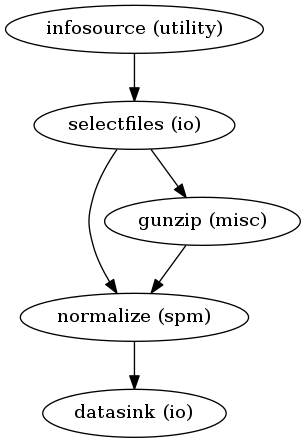

In [15]:
# Create SPM normalization graph
spmflow.write_graph(graph2use='flat', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(spmflow.base_dir, 'spmflow', 'graph.dot.png'))

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the SPM normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [16]:
spmflow.run('MultiProc', plugin_args={'n_procs': 4})

170928-23:31:23,429 workflow INFO:
	 Workflow spmflow settings: ['check', 'execution', 'logging']
170928-23:31:23,486 workflow INFO:
	 Running in parallel.
170928-23:31:23,492 workflow INFO:
	 Executing: selectfiles.a5 ID: 0
170928-23:31:23,499 workflow INFO:
	 Executing: selectfiles.a4 ID: 4
170928-23:31:23,501 workflow INFO:
	 Executing node selectfiles.a5 in dir: /output/workingdir/spmflow/_fwhm_id_8_subject_id_sub-270/selectfiles
170928-23:31:23,517 workflow INFO:
	 Executing: selectfiles.a3 ID: 8
170928-23:31:23,520 workflow INFO:
	 Executing node selectfiles.a4 in dir: /output/workingdir/spmflow/_fwhm_id_4_subject_id_sub-270/selectfiles170928-23:31:23,526 workflow INFO:
	 Executing: selectfiles.a2 ID: 12

170928-23:31:23,529 workflow INFO:
	 Executing node selectfiles.a3 in dir: /output/workingdir/spmflow/_fwhm_id_8_subject_id_sub-256/selectfiles
170928-23:31:23,540 workflow INFO:
	 Executing node selectfiles.a2 in dir: /output/workingdir/spmflow/_fwhm_id_4_subject_id_sub-256/sel

	 sub: /output/datasink/norm_spm/_fwhm_id_8_subject_id_sub-270/wsub-270_T1w_preproc.nii -> /output/datasink/norm_spm/sub-270_fwhm8/wsub-270_T1w_preproc.nii
170928-23:38:07,268 workflow INFO:
	 [Job finished] jobname: datasink.a5 jobid: 3
170928-23:38:08,702 workflow INFO:
	 [Job finished] jobname: normalize.a4 jobid: 6
170928-23:38:08,704 workflow INFO:
	 Executing: datasink.a4 ID: 7
170928-23:38:08,747 workflow INFO:
	 Executing node datasink.a4 in dir: /output/workingdir/spmflow/_fwhm_id_4_subject_id_sub-270/datasink
170928-23:38:08,807 interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_sub-270/wcon_0001.nii -> /output/datasink/norm_spm/sub-270_fwhm4/wcon_0001.nii
170928-23:38:08,824 interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_sub-270/wcon_0002.nii -> /output/datasink/norm_spm/sub-270_fwhm4/wcon_0002.nii
170928-23:38:08,837 interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_sub-270/wcon_0003.nii -> /output/datasink/no

# Comparison between ANTs and SPM normalization

Now that we ran the normalization with ANTs and SPM, let us compare their output.

In [21]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
anatimg = '/data/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

First, let's compare the normalization of the **anatomical** images:

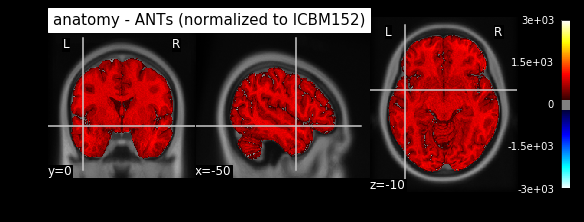

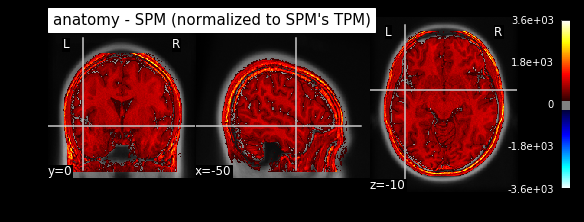

In [22]:
subject_id = 'sub-222'


plot_stat_map(
    '/data/derivatives/fmriprep/sub-222/anat/sub-222_T1w_space-mni152nlin2009casym_preproc.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))
plot_stat_map(
    '/output/datasink/norm_spm/sub-222_fwhm4/wsub-222_T1w_preproc.nii',
    title='anatomy - SPM (normalized to SPM\'s TPM)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))

And what about the **contrast** images for **Finger > others**?

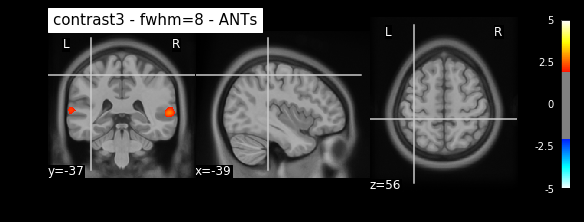

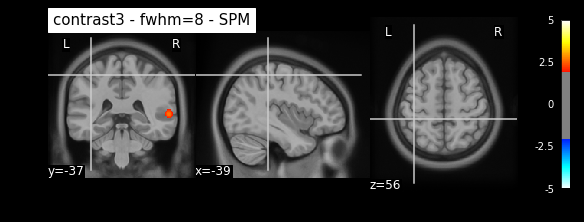

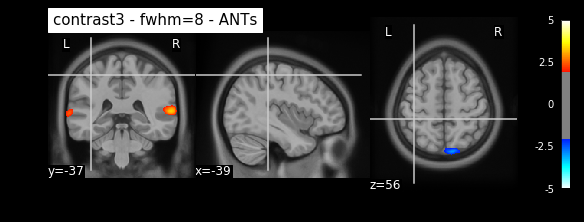

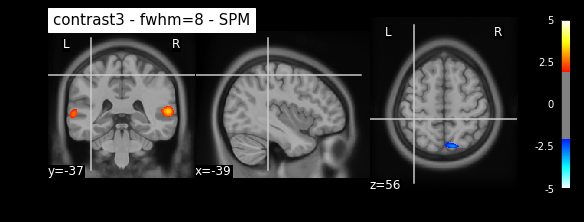

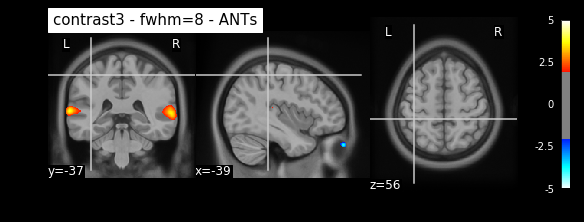

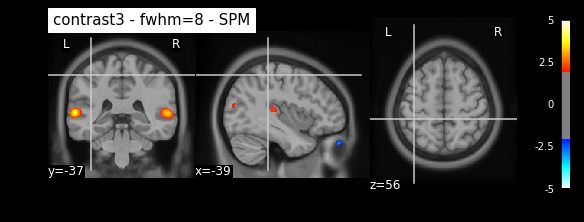

In [23]:
for subject_id in subject_list:

    plot_stat_map(
        '/output/datasink/norm_ants/' + subject_id + '_fwhm8/con_0003_trans.nii', title='contrast3 - fwhm=8 - ANTs',
        bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56))
    plot_stat_map(
        '/output/datasink/norm_spm/' + subject_id + '_fwhm8/wcon_0003.nii', title='contrast3 - fwhm=8 - SPM',
        bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56))

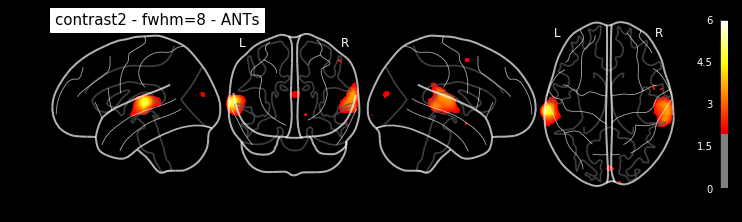

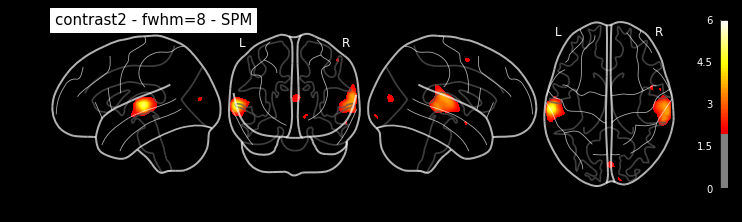

In [29]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink/norm_ants/sub-222_fwhm8/con_0001_trans.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=6, title='contrast2 - fwhm=8 - ANTs')
plot_glass_brain(
    '/output/datasink/norm_spm/sub-222_fwhm8/wcon_0001.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=6, title='contrast2 - fwhm=8 - SPM')